<a href="https://colab.research.google.com/github/Mirco-Nani/experiments_gradient_accumulation/blob/main/notebooks/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing gradient accumulation in keras

This example demonstrates how to implement gradient accumulation in Keras  
It is followed by a qualitative comparison between:
* usage of keras .fit() method
* usage of custom train loop
* different batch sizes
* usage of gradient accumulation vs standard practices


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
class DsInfo:
  def __init__(self, ds, batch_size, num_examples):
    self.ds=ds
    self.batch_size=batch_size
    self.num_examples = num_examples
    
  def num_batches(self):
    return np.ceil(self.num_examples/self.batch_size).astype(int)



def plot_history(history):
  plt.figure(figsize=(20,10))

  plt.subplot(221)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'])

  plt.subplot(222)
  plt.plot(history['sparse_categorical_accuracy'])
  plt.plot(history['val_sparse_categorical_accuracy'])
  plt.title('model sparse_categorical_accuracy')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'])

  plt.show()


def prepare_ds(batch_size=128, cache=True, shuffle=True):
  def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

  (ds_train, ds_test), ds_info = tfds.load(
      'fashion_mnist',
      split=['train', 'test'],
      shuffle_files=shuffle,
      as_supervised=True,
      with_info=True,
  )

  ds_train = ds_train.map(
      normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if cache: ds_train = ds_train.cache()
  if shuffle: ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
  ds_train = ds_train.batch(batch_size)
  ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

  ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.batch(batch_size)
  if cache: ds_test = ds_test.cache()
  ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)
  return (
      DsInfo(ds_train, batch_size, ds_info.splits['train'].num_examples),
      DsInfo(ds_test, batch_size, ds_info.splits['test'].num_examples)
      )



def build_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(10)
  ])
  return model


def build_and_train(ds_train, ds_test, epochs):
  model = build_model()

  model.compile(
      optimizer=tf.keras.optimizers.Adam(0.001),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

  history = model.fit(
      ds_train.ds,
      epochs=6,
      validation_data=ds_test.ds,
  )

  return history.history


def build_and_custom_train(ds_train, ds_test, epochs):
  model = build_model()

  optimizer=tf.keras.optimizers.Adam(0.001)
  loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  accuracy=tf.keras.metrics.SparseCategoricalAccuracy()
  
  history={'loss':[], 'val_loss':[], 'sparse_categorical_accuracy':[], 'val_sparse_categorical_accuracy':[]}

  for epoch in range(epochs):
    losses, accuracies = [], []
    val_losses, val_accuracies = [], []
    train = ds_train.ds
    valid = ds_test.ds
    accuracy.reset_state()
    for step, (images, labels) in tqdm(enumerate(train), desc=f"Training epoch {epoch}", total=ds_train.num_batches()):
      with tf.GradientTape(persistent=True) as tape:
        logits=model(images)
        loss=loss_function(labels, logits)
      gradients = tape.gradient(loss, model.trainable_weights)
      del tape #?

      optimizer.apply_gradients(zip(gradients, model.trainable_weights))
      step_loss = loss.numpy()
      losses.append(step_loss)

      accuracy.update_state(labels, logits)
    
    history['loss'].append(sum(losses) / len(losses))
    history['sparse_categorical_accuracy'].append(accuracy.result().numpy())

    accuracy.reset_state()
    for step, (images, labels) in tqdm(enumerate(valid), desc=f"Validating epoch {epoch}", total=ds_test.num_batches()):
      logits=model(images)
      val_losses.append(loss_function(labels, logits).numpy())
      accuracy.update_state(labels, logits)
      val_accuracies.append(accuracy.result().numpy())

    history['val_loss'].append(sum(val_losses) / len(val_losses))
    history['val_sparse_categorical_accuracy'].append(sum(val_accuracies) / len(val_accuracies))
  
  return history
    

def build_and_gradient_accumulation_train(ds_train, ds_test, epochs, accumulation_steps):
  model = build_model()

  optimizer=tf.keras.optimizers.Adam(0.001)
  loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  accuracy=tf.keras.metrics.SparseCategoricalAccuracy()
  
  history={'loss':[], 'val_loss':[], 'sparse_categorical_accuracy':[], 'val_sparse_categorical_accuracy':[]}

  for epoch in range(epochs):
    losses, accuracies = [], []
    val_losses, val_accuracies = [], []
    train = ds_train.ds
    valid = ds_test.ds
    accuracy.reset_state()

    for step, (images, labels) in tqdm(enumerate(train), desc=f"Training epoch {epoch}", total=ds_train.num_batches()):
      acc_step_size = int(ds_train.batch_size/accumulation_steps)
      acc_gradients = [tf.zeros_like(v) for v in model.trainable_weights]
      num_gradients=0
      for acc_step in range(0, accumulation_steps, acc_step_size):
        acc_images, acc_labels = images[acc_step:acc_step+acc_step_size], labels[acc_step:acc_step+acc_step_size]
        with tf.GradientTape(persistent=True) as tape:
          logits=model(acc_images)
          loss=loss_function(acc_labels, logits)
        gradient = tape.gradient(loss, model.trainable_weights)
        acc_gradients = [(acum_grad+grad) for acum_grad, grad in zip(acc_gradients, gradient)]
        num_gradients += 1
        del tape 

        step_loss = loss.numpy()
        losses.append(step_loss)
        accuracy.update_state(acc_labels, logits)

      gradients = [grad/num_gradients for grad in acc_gradients]
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    history['loss'].append(sum(losses) / len(losses))
    history['sparse_categorical_accuracy'].append(accuracy.result().numpy())

    accuracy.reset_state()
    for step, (images, labels) in tqdm(enumerate(valid), desc=f"Validating epoch {epoch}", total=ds_test.num_batches()):
      logits=model(images)
      val_losses.append(loss_function(labels, logits).numpy())
      accuracy.update_state(labels, logits)
      val_accuracies.append(accuracy.result().numpy())

    history['val_loss'].append(sum(val_losses) / len(val_losses))
    history['val_sparse_categorical_accuracy'].append(sum(val_accuracies) / len(val_accuracies))
  
  return history




def task(batch_size=128, cache_ds=True, epochs=6, deterministic=True):
  if deterministic:
    tf.random.set_seed(1234)
  ds_train, ds_test = prepare_ds(batch_size, cache_ds, shuffle=(not deterministic))
  history=build_and_train(ds_train, ds_test, epochs)
  plot_history(history)


def custom_task(batch_size=128, cache_ds=True, epochs=6, deterministic=True):
  if deterministic:
    tf.random.set_seed(1234)
  ds_train, ds_test = prepare_ds(batch_size, cache_ds, shuffle=(not deterministic))
  history=build_and_custom_train(ds_train, ds_test, epochs)
  plot_history(history)


def gradient_accumulation_task(batch_size=128, cache_ds=True, epochs=6, deterministic=True, accumulation_steps=1):
  if deterministic:
    tf.random.set_seed(1234)
  ds_train, ds_test = prepare_ds(batch_size, cache_ds, shuffle=(not deterministic))
  history=build_and_gradient_accumulation_train(ds_train, ds_test, epochs, accumulation_steps)
  plot_history(history)


In [ ]:
task()

In [ ]:
task()

In [ ]:
task(cache_ds=False)

In [ ]:
task(batch_size=8)

In [ ]:
custom_task()

In [ ]:
gradient_accumulation_task()

In [ ]:
gradient_accumulation_task(accumulation_steps=16)

In [ ]:
gradient_accumulation_task(epochs=10)

In [ ]:
gradient_accumulation_task(batch_size=32768, epochs=10)

In [ ]:
gradient_accumulation_task(batch_size=32768, epochs=10, accumulation_steps=int(32768/128) ) #accumulation_steps=256

# Results

Custom loop | batch_size=128 | no gradient accumulation

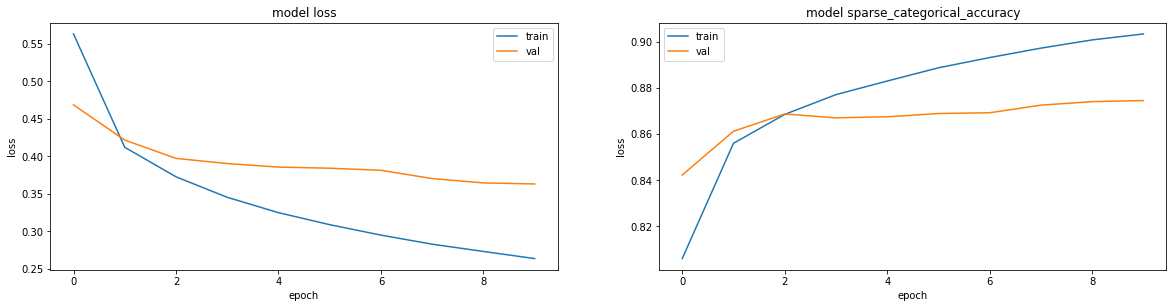
  
Custom loop | batch_size=128 | **256 gradient accumulations (total gradients: 32K)**
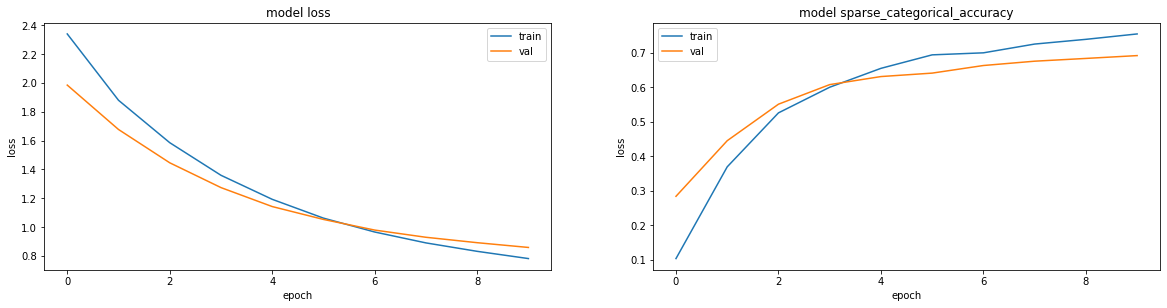
  
Custom loop | batch_size=32K | no gradient accumulation
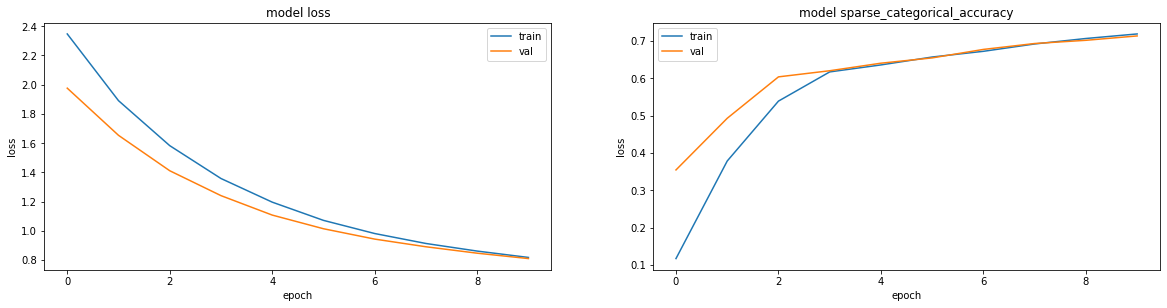

* no visible changes in train trends
* eval trends get better with gradient accumulation
* big batch size is still better than the equivalent gradient accumulation with small batch size (maybe the code can be improved?)


# Next steps
* Need to find a task with training that is a little unstable, so I can test if gradient accumulation actually helps with stability as increasing the batch size does